In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9557789605936914635
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15134713447
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11086393236546703148
physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df = pd.read_csv('./train.csv')
print("size of train_df:", len(train_df))

# 데이터 노이즈 수정
train_df.loc[train_df['id'] == 3896, 'artist'] = 'Titian'
train_df.loc[train_df['id'] == 3986, 'artist'] = 'Alfred Sisley'

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    validation_split=0.10
)

TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="training"
)

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="validation"
)

size of train_df: 5911
Found 5320 validated image filenames belonging to 50 classes.
Found 591 validated image filenames belonging to 50 classes.


In [ ]:
# ResNet50 모델 로드
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(244, 244, 3), pooling=None, input_tensor=None)

# 새로운 Fully Connected Layer 추가
x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x) # 드롭아웃 추가
predictions = Dense(50, activation='softmax')(x)

#전체 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer=Adam(lr=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
CP = ModelCheckpoint(filepath='vgg19_model/' + 'VGG19-Sigmoid-{epoch:03d}-{accuracy:.4f}-{val_loss:.4f}.hdf5',
                     monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.00005)
CALLBACK = [CP, LR]

In [ ]:
# 모델 학습
history = model.fit(TRAIN_GENERATOR,
                    epochs=50,
                    validation_data=VALID_GENERATOR,
                    callbacks=CALLBACK,
)

Train for 167 steps, validate for 19 steps
Epoch 1/50
166/167 [============================>.] - ETA: 0s - loss: 3.6560 - accuracy: 0.0998
Epoch 00001: val_loss improved from inf to 3.52617, saving model to vgg19_model/VGG19-Sigmoid-001-0.1002-3.5262.hdf5
167/167 [==============================] - 151s 906ms/step - loss: 3.6553 - accuracy: 0.1002 - val_loss: 3.5262 - val_accuracy: 0.1117
Epoch 2/50
166/167 [============================>.] - ETA: 0s - loss: 3.3543 - accuracy: 0.1505
Epoch 00002: val_loss improved from 3.52617 to 3.35312, saving model to vgg19_model/VGG19-Sigmoid-002-0.1506-3.3531.hdf5
167/167 [==============================] - 141s 843ms/step - loss: 3.3541 - accuracy: 0.1506 - val_loss: 3.3531 - val_accuracy: 0.1641
Epoch 3/50
166/167 [============================>.] - ETA: 0s - loss: 3.2140 - accuracy: 0.1687
Epoch 00003: val_loss improved from 3.35312 to 3.25331, saving model to vgg19_model/VGG19-Sigmoid-003-0.1688-3.2533.hdf5
167/167 [==============================]

Epoch 26/50
166/167 [============================>.] - ETA: 0s - loss: 2.3712 - accuracy: 0.3374
Epoch 00026: val_loss did not improve from 2.54309
167/167 [==============================] - 141s 842ms/step - loss: 2.3691 - accuracy: 0.3376 - val_loss: 2.5633 - val_accuracy: 0.3198
Epoch 27/50
166/167 [============================>.] - ETA: 0s - loss: 2.3389 - accuracy: 0.3457
Epoch 00027: val_loss improved from 2.54309 to 2.49778, saving model to vgg19_model/VGG19-Sigmoid-027-0.3470-2.4978.hdf5
167/167 [==============================] - 141s 843ms/step - loss: 2.3353 - accuracy: 0.3470 - val_loss: 2.4978 - val_accuracy: 0.3130
Epoch 28/50
166/167 [============================>.] - ETA: 0s - loss: 2.3192 - accuracy: 0.3529
Epoch 00028: val_loss did not improve from 2.49778
167/167 [==============================] - 142s 853ms/step - loss: 2.3178 - accuracy: 0.3536 - val_loss: 2.5382 - val_accuracy: 0.3283
Epoch 29/50
166/167 [============================>.] - ETA: 0s - loss: 2.2964 - a

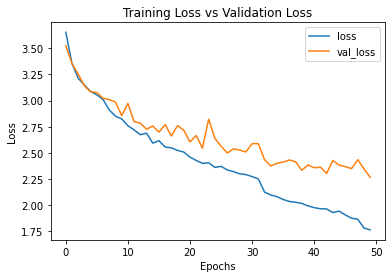

In [ ]:
# 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

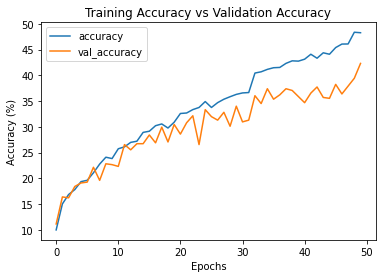

In [ ]:
# 정확도 그래프
plt.plot([x * 100 for x in history.history['accuracy']])
plt.plot([x * 100 for x in history.history['val_accuracy']])
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
# 최신 체크포인트 파일 찾기
checkpoint_files = glob.glob('vgg19_model/*.hdf5')
latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

# 모델에 최신 가중치 로드
model.load_weights(latest_checkpoint)

# Validation 데이터에 대한 정확도 확인
val_loss, val_accuracy = model.evaluate(VALID_GENERATOR)
print('Validation Loss:', round(val_loss, 6))
print('Validation Accuracy:', round(val_accuracy, 3))

19/19 [==============================] - 10s 541ms/step - loss: 2.1942 - accuracy: 0.4315
Validation Loss: 2.194184
Validation Accuracy: 0.431


In [ ]:
test_df = pd.read_csv('test.csv')

TEST_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=test_df,
    x_col='img_path',
    y_col='id',
    target_size=(244, 244),
    class_mode='raw',
    batch_size=32,
    shuffle=False,
)

TEST_GENERATOR.reset()

# 최신 체크포인트 파일 찾기
checkpoint_files = glob.glob('vgg19_model/*.hdf5')
latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

print(latest_checkpoint)

# 모델에 최신 가중치 로드
model.load_weights(latest_checkpoint)

test_prediction = model.predict(TEST_GENERATOR, verbose=1)
display(test_prediction)

Found 12670 validated image filenames.
vgg19_model\VGG19-Sigmoid-050-0.4825-2.2654.hdf5
396/396 [==============================] - 189s 477ms/step


array([[6.16194666e-05, 1.09898083e-05, 1.85555339e-01, ...,
        1.00058387e-05, 1.30792474e-02, 1.20813907e-04],
       [1.75350986e-03, 2.42530969e-05, 1.13053834e-02, ...,
        2.82198853e-05, 1.27078341e-02, 1.34294899e-02],
       [9.82307611e-05, 1.08317035e-04, 5.17472904e-03, ...,
        3.62694875e-04, 3.49537493e-03, 4.65273013e-04],
       ...,
       [2.67437048e-04, 2.34603620e-04, 3.88920121e-02, ...,
        2.38505218e-05, 2.18144748e-02, 6.32508053e-03],
       [1.16300199e-03, 1.23478560e-04, 6.32713782e-03, ...,
        2.18829697e-07, 1.14085730e-02, 1.98161299e-03],
       [2.54751594e-05, 9.53583687e-04, 7.67002814e-03, ...,
        7.58117130e-06, 6.14700913e-02, 7.07464234e-04]], dtype=float32)

In [ ]:
test_prediction = np.argmax(test_prediction, axis = 1)
test_prediction

array([ 9, 10, 10, ..., 10, 15, 46], dtype=int64)

In [ ]:
test_prediction_df = pd.DataFrame(test_prediction, columns = ['artist'])
test_prediction_df

,artist
0,9
1,10
2,10
3,0
4,33
...,...
12665,35
12666,45
12667,10
12668,15


In [ ]:
label_encoder = LabelEncoder()
artist_df = train_df.copy()
artist_le = label_encoder.fit_transform(artist_df['artist'].values)
artist_df['num'] = artist_le
artist_df = artist_df.drop('id', axis=1)
artist_df = artist_df.drop('img_path', axis=1)
artist_df.head()

,artist,num
0,Diego Velazquez,9
1,Vincent van Gogh,48
2,Claude Monet,7
3,Edgar Degas,10
4,Hieronymus Bosch,24


In [ ]:
test_prediction_dic = test_prediction_df.to_dict()
test_prediction_values = test_prediction_dic['artist'].values()
test_prediction_list = list(test_prediction_values)
test_prediction_list[:5]

[9, 10, 10, 0, 33]

In [ ]:
artist_df.set_index('num', inplace=True)
artist_df

,artist
num,
9,Diego Velazquez
48,Vincent van Gogh
7,Claude Monet
10,Edgar Degas
24,Hieronymus Bosch
...,...
40,Pieter Bruegel
37,Peter Paul Rubens
35,Paul Gauguin


In [ ]:
artist_df = artist_df.sort_index()
artist_df

,artist
num,
0,Albrecht Du rer
0,Albrecht Du rer
0,Albrecht Du rer
0,Albrecht Du rer
0,Albrecht Du rer
...,...
49,William Turner
49,William Turner
49,William Turner


In [ ]:
artist_info_dic = artist_df['artist'].to_dict()
artist_info_dic

{0: 'Albrecht Du rer',
 1: 'Alfred Sisley',
 2: 'Amedeo Modigliani',
 3: 'Andrei Rublev',
 4: 'Andy Warhol',
 5: 'Camille Pissarro',
 6: 'Caravaggio',
 7: 'Claude Monet',
 8: 'Diego Rivera',
 9: 'Diego Velazquez',
 10: 'Edgar Degas',
 11: 'Edouard Manet',
 12: 'Edvard Munch',
 13: 'El Greco',
 14: 'Eugene Delacroix',
 15: 'Francisco Goya',
 16: 'Frida Kahlo',
 17: 'Georges Seurat',
 18: 'Giotto di Bondone',
 19: 'Gustav Klimt',
 20: 'Gustave Courbet',
 21: 'Henri Matisse',
 22: 'Henri Rousseau',
 23: 'Henri de Toulouse-Lautrec',
 24: 'Hieronymus Bosch',
 25: 'Jackson Pollock',
 26: 'Jan van Eyck',
 27: 'Joan Miro',
 28: 'Kazimir Malevich',
 29: 'Leonardo da Vinci',
 30: 'Marc Chagall',
 31: 'Michelangelo',
 32: 'Mikhail Vrubel',
 33: 'Pablo Picasso',
 34: 'Paul Cezanne',
 35: 'Paul Gauguin',
 36: 'Paul Klee',
 37: 'Peter Paul Rubens',
 38: 'Pierre-Auguste Renoir',
 39: 'Piet Mondrian',
 40: 'Pieter Bruegel',
 41: 'Raphael',
 42: 'Rembrandt',
 43: 'Rene Magritte',
 44: 'Salvador Dali',


In [ ]:
artist_name = []
for i in test_prediction_list:
    artist_name.append(artist_info_dic[i])
artist_name[:5]

['Diego Velazquez',
 'Edgar Degas',
 'Edgar Degas',
 'Albrecht Du rer',
 'Pablo Picasso']

In [ ]:
submission_df = pd.read_csv("./sample_submission.csv")
submission_df = submission_df.drop('artist', axis=1)
submission_df.head()

,id
0,TEST_00000
1,TEST_00001
2,TEST_00002
3,TEST_00003
4,TEST_00004


In [ ]:
submission_df['artist'] = artist_name
submission_df.head()

,id,artist
0,TEST_00000,Diego Velazquez
1,TEST_00001,Edgar Degas
2,TEST_00002,Edgar Degas
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Pablo Picasso


In [ ]:
submission_df.to_csv("vgg19_submission.csv", index=False)